# CQMOM vs DSMC for Droplet Breakup in 2D

### Import useful libraries, setting directory and number of cores for parallelization

In [1]:
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import itertools
import utils.flux_calculator as flx
import Quadrature.CQMOM as CQMOM
from utils.testing_utils import MC_multinormal_moments

import json
from matplotlib.backends.backend_pdf import PdfPages
import concurrent.futures
import multiprocessing as mp
from tqdm import tqdm
from pathlib import Path


##########################################################################################
# Creation of the file in order to store the datas
plt.rcParams.update({'font.size': 18})
folder_name = "MTE_2D_Droplet_Breakup_notebook_output"
os.makedirs(folder_name, exist_ok=True)

# Choose the number of processor cores for your MC simulation (parallelization mandatory)
max_workers = 4      # max_workers = min(os.cpu_count()-3 or 1, 8)


### Definition of class & functions for the JSON file

In [2]:
# Useful to visualize the evolution of the droplets
# Valid only for MC, it doesn't make any sense for CQMOM.
"""The json file output look like :

{"metadata": {"description": "Actives droplets radius for each time step", "units": "m (meters)", "time_step": 1e-06, "simulation_time": 0.003, "num_time_steps": 3000, "initial_particles": 7, "max_particles": 1750}, 
"data": [
[0.0010738527171881276, 0.0010191246262320451, 0.0010208059853122936, 0.0012238418840626556, 0.0009114659084485765, 0.0010101974973333917, 0.0011413607671301594],
[0.0010730064968557179, 0.0010182267622968991, 0.001019899085124179, 0.0012229717498004327, 0.0009105894975770784, 0.0010093510080411484, 0.0011404540738557752],
, etc......] }
}"""

class RadiiWriterJSONL:
    """Write a frame per line for a branch (from parallelization)."""
    def __init__(self, path: str | Path):
        self.path = Path(path)
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.f = open(self.path, "w", buffering=1)  # line-buffered
        self._i = 0

    def append(self, radii_iterable):
        arr = [float(r) for r in radii_iterable]
        if self._i:
            self.f.write("\n")
        self.f.write(json.dumps(arr))
        self._i += 1
        if (self._i % 200) == 0:
            self.f.flush()

    def close(self):
        self.f.close()

def merge_branch_jsonl_to_global_json(
    radii_paths, out_json_path, *,
    time_step, num_loops,
    num_particles, max_particles,
    simulation_time=None,  # if None -> num_loops * time_step
    strict_lengths=True    # True: suggest >= num_loops lines per branches
):
    # 1) vérification optionnelle des longueurs
    if strict_lengths:
        counts = [sum(1 for _ in open(p, "r")) for p in radii_paths]
        too_short = [(p,c) for p,c in zip(radii_paths, counts) if c < num_loops]
        if too_short:
            msg = ", ".join(f"{Path(p).name}({c}<{num_loops})" for p,c in too_short)
            raise ValueError(f"Incomplete branch for the fusion: {msg}")
        # correct the position of cursors for the true reading
    files = [open(p, "r") for p in radii_paths]

    if simulation_time is None:
        simulation_time = float(num_loops * time_step)

    Path(out_json_path).parent.mkdir(parents=True, exist_ok=True)
    try:
        with open(out_json_path, "w") as out:
            # --- métadonnées ---
            meta = {
                "description": "Actives droplets radius for each time step",
                "units": "m (meters)",
                "time_step": float(time_step),
                "simulation_time": float(simulation_time),
                "num_time_steps": int(num_loops),
                "initial_particles": int(num_particles),
                "max_particles": int(max_particles),
            }
            out.write('{"metadata": ')
            out.write(json.dumps(meta, ensure_ascii=False))
            out.write(', "data": [\n')

            first = True
            for k in range(num_loops):
                merged = []
                for f in files:
                    line = f.readline()
                    if not line:
                        # strict: error; else, fusion [] and continue
                        raise ValueError(f"Branch depleted at frame {k} (expected {num_loops}).")
                    merged.extend(json.loads(line))
                if not first:
                    out.write(",\n")
                out.write(json.dumps(merged))
                first = False

            out.write("\n]}\n")
    finally:
        for f in files:
            try: f.close()
            except: pass

def cleanup_branch_jsonl(radii_paths, *, verbose=True):
    """Delete the intermediaries JSONL written by each branch."""
    for p in radii_paths:
        p = Path(p)
        try:
            p.unlink()
            if verbose:
                print(f"Deleted : {p.name}")
        except FileNotFoundError:
            if verbose:
                print(f"Already absent : {p.name}")
        except PermissionError as e:
            print(f"Impossible to delete {p.name} (used elsewhere ?) : {e}")



### Simulation settings

In [3]:
dim = 2
time_step = 1e-6  

num_particles = 3   # Number of droplets initially
max_nb_fragmentation = 250   # Max number of fragmented droplets originated for only one droplet
max_particles = max_nb_fragmentation * num_particles  # Max number of all fragmented droplets (length of the list stocked in memory)

simulation_time = 3000*time_step  
num_loops = int(simulation_time/time_step)
t_span = (0, time_step * num_loops)
t_eval = np.linspace(t_span[0], t_span[1], num_loops)

### Constants and Physical properties

In [4]:
"""Injection configuration - You can choose whatever you want but don't forget that the work here was done for injection configuration
It may worked for other cases but be sure to check if the physical models are consistent
"""

# Gas properties
Temperature = 1200.0  # Temperature (K)
Pression = 5.0*10**5  # Pressure (Pa)
rhog = 1.293*(273.15/Temperature)*(Pression/101325)  # Density of the gaz (kg/m³)
ug = -20  # Speed (Negative = in a opposite way compare to the droplets, Positive = same way)
mug = 1.716*(10**(-5))*((Temperature/273.15)**(3/2))*((273.15 + 110.4) / Temperature + 110.4)  # Viscosity (dynamic) (Pa.s)

# Liquid properties
rhol = 800.0  # Density (kg/m³)
sigmal = 25*10**(-3)  # Surface tension (N/m)
mul = 1.5*10**(-3)  # Viscosity (dynamic) (Pa.s)

# Diameter of the nozzle if needed
d0 = 2e-3  # 2 mm nozzle diameter

### Initial distribution

In [5]:
# Initial centered value of the droplets radius
r0 = d0/2  # Radius (m)
# Initial centered value of the droplets speed
u0 = 100 # Speed (m/s)

# Distribution parameters : ( dimension 1: radius (r), dimension 2: speed (u) )
mu = np.array([r0, u0])  # Mean of the distribution [initial radius, initial speed]
cov = np.diag([(0.10*r0)**2, (0.05*u0)**2])  # Standard deviation of the distribution : here 10% radius and 5% speed

# Initial conditions 
N = tuple([2 for _ in range(dim)])  # Number of moments for each dimension
moments_idx = np.array(N)

mc_moments = []
mc_points = []
mc_weights = []
initial_moments = []   # initial moments of droplets
initial_radii = []     # initial radius of droplets
initial_volume = []    # initial volume of droplets

# Configuration of those six lists
for i in range(num_particles):
    mc_moments_i, mc_points_i, mc_weights_i = MC_multinormal_moments(mu, cov, 2*moments_idx, 1)

    # Extend the list to allocate more space for new droplets created by fragmentation
    mc_points_extended_i = np.zeros((max_nb_fragmentation, dim))
    mc_weights_extended_i = np.zeros(max_nb_fragmentation)
    initial_radii_i = np.zeros(max_nb_fragmentation)

    # Copy the initial particles
    mc_points_extended_i[:1] = mc_points_i
    mc_weights_extended_i[:1] = mc_weights_i

    # Initialize the radius (first dimension = radius)
    initial_radii_i[:1] = mc_points_i[:, 0]
    initial_radii_i[1:] = 0.0  # Inactive particles

    # Initialize the volumes
    initial_volume_i = np.sum([((4/3)*np.pi*r**3) for r in initial_radii_i])

    # Update the global pointers
    mc_points_i = mc_points_extended_i
    mc_weights_i = mc_weights_extended_i

    # Initialize the moments
    initial_moments_i = np.zeros(2*moments_idx)
    # Assume moments_idx is a list or tuple of length d, where d is the number of dimensions
    ranges = [range(2 * idx) for idx in moments_idx]
    for idx in itertools.product(*ranges):
        initial_moments_i[idx] = mc_moments_i[idx]
    
    # Append all the initializations to the our lists
    mc_moments.append(mc_moments_i)
    mc_points.append(mc_points_i)
    mc_weights.append(mc_weights_i)
    initial_moments.append(initial_moments_i)
    initial_radii.append(initial_radii_i)
    initial_volume.append(initial_volume_i)

### Global variables for fragmentation logic

In [6]:
num_active_particles = num_particles     # Number of active particles
fragmentation_count = 0  # Fragmentation counter

### Helper Functions

In [7]:
def Weber(rho, u, r, sigmal):
    return rho*(abs(u)**2)*(2*r)/sigmal

def Reynolds(rho, u, r, mu):
    return rho*abs(u)*2*r/mu

def Ohnesorge(rho, u, r, sigmal, mu):

    We = Weber(rho, u, r, sigmal)
    Re = Reynolds(rho, u, r, mu)

    if We < 0 or Re < 0.00000001 or np.isnan(We) or np.isnan(Re):
        return 0.0

    return np.sqrt(We)/Re

def Cd(rhog, u, r, mug):
    Re = Reynolds(rhog, u, r, mug)
    
    if Re <= 0.01:
        return (24/0.01)*(1 + 0.1315*0.01**(0.82-0.05*np.log10(0.01)))
    elif 0.01 < Re <= 20:
        return (24/Re)*(1 + 0.1315*Re**(0.82-0.05*np.log10(Re)))
    elif 20 < Re <= 260:
        return (24/Re)*(1 + 0.1935*Re**0.6305)
    else:
        return (24/260)*(1 + 0.1935*260**0.6305)

def Heaviside(x):
    if x < 0:
        return 0
    else:
        return 1

# Initial numbers for our simulation (check if fragmentation can occur)
We_initial = Weber(rhog, abs(u0-ug), r0, sigmal)
Re_initial = Reynolds(rhog, abs(u0-ug), r0, mug)
Oh_initial = np.sqrt(We_initial)/Re_initial

### Physical Models : dudt & drdt (evolution of two dimensions)

In [8]:
# The evolution of the speed here is only due to drag
def dudt_function(rhog, rhol, tab_r, ug, tab_u):

    dudt = []
    for i in range(len(tab_r)):

         # Protection against invalid values
        if tab_r[i] <= 0 or np.isnan(tab_r[i]) or np.isinf(tab_r[i]):
            dudt.append(0.0)
            continue
        if np.isnan(tab_u[i]) or np.isinf(tab_u[i]):
            dudt.append(0.0)
            continue
        
        dudt_i = (3/8)*Cd(rhog, tab_u[i]-ug, tab_r[i], mug)*(rhog/rhol)*(1/tab_r[i])*abs(ug-tab_u[i])*(ug-tab_u[i])
        
        # Final protection against NaN/inf
        if np.isnan(dudt_i) or np.isinf(dudt_i):
            dudt.append(0.0)
            continue
        
        dudt.append(dudt_i)
        
    return dudt


# The evolution of the radius is modeled mainly with the RD model
def drdt_with_fragmentation_shrinkage(tab_r, tab_u, t, rhog, ug, sigmal, mug):
    
    drdt = []

    for i in range(len(tab_r)):
        
        # Protection against invalid values
        if tab_r[i] <= 0 or np.isnan(tab_r[i]) or np.isinf(tab_r[i]):
            drdt.append(0.0)
            continue
        if np.isnan(tab_u[i]) or np.isinf(tab_u[i]):
            drdt.append(0.0)
            continue
        if abs(tab_u[i] - ug) < 1e-10:  # Vitesse relative très faible
            drdt.append(0.0)
            continue
        
        We_g = Weber(rhog, tab_u[i]-ug, tab_r[i], sigmal)
        Re_g = Reynolds(rhog, tab_u[i]-ug, tab_r[i], mug)
        Oh = Ohnesorge(rhog, tab_u[i]-ug, tab_r[i], sigmal, mug)
        Wecrit = 12*(1 + 1.077*Oh**1.6)
        
        # Protection against invalid values
        if We_g <= 0 or Re_g <= 0:
            drdt.append(0.0)
            continue
        if np.isnan(We_g) or np.isnan(Re_g): 
            drdt.append(0.0)
            continue
        if np.isinf(We_g) or np.isinf(Re_g):
            drdt.append(0.0)
            continue

        # # Calculation of rchild not like in RD model but consistent with our random process
        rchild = 0.681 * tab_r[i]  # 0.681 = 1 / (2.17 + 1)**(1/3) where 2.17 is the mean value of the distribution of the number of child formed by one droplet (between 1 and 5 here, the parent droplet doesn't die)

        
        # Calculation of taubag with protection
        try:
            taubag = np.pi * ((rhol*tab_r[i]**3)/(2*sigmal))**(1/2)   # Characteristic time of breakup in bag breakup mode
            if np.isnan(taubag) or np.isinf(taubag) or taubag <= 0:
                drdt.append(0.0)
                continue
        except:
            drdt.append(0.0)
            continue
        
        # Calculation of tausheer with protection
        try:
            B2RD = 1.8   # Fixed by RD model
            if abs(tab_u[i] - ug) < 1e-10:
                drdt.append(0.0)
                continue
            tausheer = B2RD * tab_r[i] * (rhol/rhog)**(1/2) / abs(tab_u[i] - ug) # Characteristic time of breakup in sheer breakup mode
            if np.isnan(tausheer) or np.isinf(tausheer) or tausheer <= 0:
                drdt.append(0.0)
                continue
        except:
            drdt.append(0.0)
            continue
        
        # Final term for the evolution
        try:
            transition_param = We_g / np.sqrt(Re_g)
            if np.isnan(transition_param) or np.isinf(transition_param):
                drdt.append(0.0)
                continue
            
            term1 = Heaviside(We_g - 6) * (1 - Heaviside(transition_param - 0.5)) * (rchild - tab_r[i]) / taubag
            term2 = Heaviside(transition_param - 0.5) * (rchild - tab_r[i]) / tausheer

            drdt_i = Heaviside(We_g - Wecrit)*(term1 + term2)
            
            # Protection against invalid values
            if np.isnan(drdt_i) or np.isinf(drdt_i):
                drdt.append(0.0)
            else:
                drdt.append(drdt_i)
        except:
            drdt.append(0.0)

    return drdt

### MC functions

In [9]:
# For MC, the dudt and drdt functions are applied to all droplets and after we solve the system with solve_ivp for a given time_step


def particle_dynamics(t, nodes_flat):
    """
    Dynamics for all particles (used by MC function calls).
    """
    
    nodes = nodes_flat.reshape(dim, -1)
    xi = [nodes[i] for i in range(len(nodes))]
    r, u = xi

    # Dynamics including fragmentation
    drdt = drdt_with_fragmentation_shrinkage(r, u, t, rhog, ug, sigmal, mug)
    dudt = dudt_function(rhog, rhol, r, ug, u)

    # Ensure that drdt and dudt have the correct shape.
    if np.isscalar(drdt):
        drdt = np.zeros_like(r)
    if np.isscalar(dudt):
        dudt = np.zeros_like(r)
    
    result = np.hstack([drdt, dudt])
    
    # Final protection : replace all NaN/inf par 0.0
    result = np.where(np.isfinite(result), result, 0.0)
    
    return result


def solve_dynamics(start_frame=0, initial_state=None, mc_points = None):
    if mc_points is None:
        raise ValueError("mc_points must be provided explicitly.")

    # Use max_particles for the state vector's size
    if initial_state is None:
        initial_flat = np.hstack([mc_points[:,i] for i in range(dim)])
        initial_flat = initial_flat.flatten()
    else:
        initial_flat = initial_state
    
    # Adjust the simulation time according to the beginning frame
    t_start = t_span[0] + start_frame * time_step
    t_span_adjusted = (t_start, t_span[1])
    t_eval_adjusted = t_eval[start_frame:] if start_frame > 0 else t_eval
    
    sol = solve_ivp(
        particle_dynamics, t_span_adjusted, initial_flat, t_eval=t_eval_adjusted, method="DOP853", vectorized=True
    )
    return sol

### CQMOM functions

In [10]:
# For CQMOM, there are no drdt because the fragmentation is contained in the source term and, dudt is only applied to one droplet.

def particle_dynamics_single(t, xi_single):
    """
    Dynamics for a single particle (used by CQMOM function calls).
    No fragmentation logic here, just pure dynamics.
    """
    xi1, xi2 = xi_single
    r = np.array([xi1])
    u = np.array([xi2])
    
    # Dynamics without fragmentation logic (dudt returns an array of one element)
    drdt = [0.0]
    dudt = dudt_function(rhog, rhol, r, ug, u)

    # Ensure scalar output for single particle
    if np.isscalar(dudt):
        dudt = [0.0]
    if abs(dudt[0]) > 1e6:
        dudt[0] = 0.0
    
    return np.array([drdt[0], dudt[0]])

def function(t, xi, k):
    xi1, xi2 = xi
    k1, k2 = k
    
    dxi1dt, dxi2dt = particle_dynamics_single(t, xi)
    
    if k1 == 0:
        term1 = 0
    else:
        term1 = k1 * (xi1**(k1-1)) * (xi2**k2) * dxi1dt

    if k2 == 0:
        term2 = 0
    else:    
        term2 = k2 * (xi1**k1) * (xi2**(k2-1)) * dxi2dt
    
    return term1 + term2

def calculate_fragmentation_source_rate(r_node, u_node, i, j):

    # Check the given values
    if (r_node <= 0 or np.isnan(r_node) or np.isinf(r_node) or
        np.isnan(u_node) or np.isinf(u_node) or
        abs(u_node - ug) < 1e-10):
        return 0.0

    Oh_current_drop = Ohnesorge(rhog, abs(u_node-ug), r_node, sigmal, mug)
    We_current_drop = Weber(rhog, abs(u_node-ug), r_node, sigmal)
    Re_g_current_drop = Reynolds(rhog, u_node-ug, r_node, mug)
    Wecrit_current_drop = 12*(1 + 1.077*Oh_current_drop**1.6)
    try:
        transition_param = We_current_drop / np.sqrt(Re_g_current_drop)
        if np.isnan(transition_param) or np.isinf(transition_param):
            return 0.0
    except:
        return 0.0

    # Mean value of the number of droplets formed by one parent droplet (with the parent dying so between 2 and 6 here)
    nb_gouttes_formees = 3.4

    # Calcutation of the integrated term in the source term, which comes from the child radius distribution
    volume_k = (4/3)*np.pi*r_node**3
    vol_mean = volume_k/(nb_gouttes_formees)
    vol_sigma = volume_k/((nb_gouttes_formees)*12)

    mu = np.log(vol_mean**2 / np.sqrt(vol_sigma**2 + vol_mean**2))
    sigma_ln = np.sqrt(np.log(1 + (vol_sigma**2 / vol_mean**2)))

    res_double_integrale_loi_ln_moments = (u_node**j)*((3/(4*np.pi))**(i/3))*np.exp(i*mu/3 + 0.5*(i*sigma_ln/3)**2)

    # Calculations of characteristic time with protections
    try:
        taubag_k = np.pi * ((rhol*r_node**3)/(2*sigmal))**(1/2)
        if np.isnan(taubag_k) or np.isinf(taubag_k) or taubag_k <= 0:
            return 0.0
        
        B2RD = 1.8
        tausheer_k = B2RD * r_node * (rhol/rhog)**(1/2) / abs(u_node - ug)
        if np.isnan(tausheer_k) or np.isinf(tausheer_k) or tausheer_k <= 0:
            return 0.0
    except:
        return 0.0
    
    # Final term
    try:
        term1 = Heaviside(We_current_drop - 6) * (1 - Heaviside(transition_param - 0.5)) / taubag_k
        term2 = Heaviside(transition_param - 0.5) / tausheer_k

        Birth_rate_br = nb_gouttes_formees * (term1 + term2) * res_double_integrale_loi_ln_moments
        Death_rate_br = (r_node**i) * (u_node**j) * (term1 + term2)

        source_rate = Heaviside(We_current_drop - Wecrit_current_drop) * (Birth_rate_br - Death_rate_br)
        
        # Protection against invalid values
        if np.isnan(source_rate) or np.isinf(source_rate) or abs(source_rate) > 1e12:
            return 0.0
        
        return source_rate
    except:
        return 0.0

def compute_flux(t, moments, N):
    """ Compute flux using the given nodes and weights. """
    # unflatten the moments
    N1, N2 = N
    moments = moments[:2**dim*N1*N2].reshape((2*N1, 2*N2))
    
    # Vérifications pour s'assurer que les moments sont réalisables
    if moments[0, 0] <= 0:
        return np.zeros((2*N1,2*N2)).flatten()
    
    if moments[0, 0] < 1e-15:
        return np.zeros((2*N1,2*N2)).flatten()
    
    if np.any(np.isnan(moments)) or np.any(np.isinf(moments)):
        return np.zeros((2*N1,2*N2)).flatten()
    
    result = CQMOM.CQMOM(N, moments, adaptive=True,  rmin = [1e-6]*dim, eabs = [1e-10]*dim, cutoff = 1e-10)
    if result is None:
        return np.zeros((2*N1,2*N2)).flatten()
    weights, nodes = result
    
    flux = np.zeros((2*N1,2*N2))
    
    for k1 in range(2*N1):
        for k2 in range(2*N2):
            # Calculate the moment index
            moment_index = (k1, k2)
            
            # Transport flux
            flux[moment_index] += flx.zeroth_order_local_flux(t, nodes, weights, moment_index, function)
            
            # Source_term
            source_term = 0.0
            for node_idx in range(len(weights)):
                if weights[node_idx] > 0:  # Only active nodes
                    r_node = nodes[0][node_idx]  
                    u_node = nodes[1][node_idx]  
                    
                    source_rate = calculate_fragmentation_source_rate(r_node, u_node, k1, k2)
                    source_term += weights[node_idx] * source_rate
            flux[moment_index] += source_term
        
    # flatten for ivp_solve
    flux = flux.flatten()
    
    return flux

def update_moments(initial_moments, N, t, dt = 1e-2):
    """ Update moments based on the flux. """
    initial_moments_flat = initial_moments.flatten() 
    sol = solve_ivp(lambda t, moments: compute_flux(t, moments, N), [t,t+dt], initial_moments_flat, method="DOP853")
    flat_moments = sol.y[:, -1]
    updated_moments = flat_moments.reshape((2*N[0], 2*N[1]))
    return updated_moments

### Compute CQMOM and MC moments

In [11]:
# ===============================================================================
# RUN SIMULATIONS FUNCTIONS
# ===============================================================================

# We define two functions : one for the global simulation and one for the simulation of one branch, which is the fragmentation of one droplet.
# We can use parallelization because the evolution of droplets are independant. There are no coalescence or any other mecanisms that can challenge the independance of our breakup processes.
# Here, the majority of the lines of code, the long simulation time, the use of parallelization is due to MC simulation that need to treat each droplet.
# If you isolate the CQMOM simulation, you only need one short function, which will be really fast.



def run_simulation_one_droplet(initial_moments, initial_radii, mc_weights, mc_points, num_active_particles, fragmentation_count, initial_volume_branch, seed = None):
    
    # Definition of our parameters for the simulation
    num_active_particles_variable = num_active_particles
    fragmentation_count_variable = fragmentation_count
    initial_radii_variable = initial_radii
    mc_weights_variable = mc_weights
    mc_points_variable = mc_points
    rng = np.random.default_rng(seed)

    # Solve dynamics for MC reference (rayon / vitesse)
    sol = solve_dynamics(start_frame=0, initial_state=None, mc_points = mc_points_variable)

    I = np.array([i for i in range(moments_idx[0])])
    J = np.array([j for j in range(moments_idx[1])])
    current_moments = initial_moments.copy()
    MC_Moments = np.zeros((len(I), len(J), num_loops))
    CQMOM_Moments = np.zeros((len(I), len(J), num_loops))
    
    # Arrays for the number of droplets at each frame
    Num_Droplets = np.zeros(num_loops)
    
    # Datas for the droplets radius at each frame (for JSON file)
    branch_id = seed if seed is not None else os.getpid()
    radii_jsonl_path = Path(folder_name) / f"radii_branch_{branch_id}.jsonl"
    r_writer = RadiiWriterJSONL(radii_jsonl_path)

    # Useful arrays for fragmentation logic : 
    # nb_gouttes_formees_liste : array of the number of child droplets that are going to be formed by the droplet i
    # nb_fragmentation : array that counts how many times the droplets i has fragmented
    nb_gouttes_formees_liste = [0 for i in range(num_active_particles_variable)]
    nb_fragmentation = [0 for i in range(num_active_particles_variable)]

    for frame in range(num_loops):
        t_current = t_span[0] + frame * time_step

        # Update the moments
        current_moments = update_moments(current_moments, N, t_span[0] + frame*time_step, dt=time_step)
        # Adjust index after update
        sol_frame_idx = frame if sol.t[0] == t_span[0] else frame - int((sol.t[0] - t_span[0]) / time_step)
        sol_frame_idx = max(0, min(sol_frame_idx, sol.y.shape[1] - 1))
        xi = sol.y[:, sol_frame_idx].reshape(dim, -1)
        
        # Parameters for fragmentation logic
        fragmentation_occurred = False
        num_active_particles_now = num_active_particles_variable
        

        for i in range(num_active_particles_now):
            if initial_radii_variable[i] > 0:

                # =========================== Constants ==============================
                current_radius = xi[0, i]
                volume_init_goutte = (4/3)*np.pi*initial_radii_variable[i]**3

                Oh_current_drop = Ohnesorge(rhog, abs(xi[1, i]-ug), current_radius, sigmal, mug)
                We_current_drop = Weber(rhog, abs(xi[1, i]-ug), current_radius, sigmal)
                Wecrit_current_drop = 12*(1 + 1.077*Oh_current_drop**1.6)
                Re_g_current_drop = Reynolds(rhog, abs(xi[1, i]-ug), current_radius, mug)
                try:
                    transition_param = We_current_drop / np.sqrt(Re_g_current_drop)
                    if np.isnan(transition_param) or np.isinf(transition_param):
                        transition_param = 0.0
                except:
                    transition_param = 0.0
                
                # ========================= Number of child droplets =======================
                target_mode = 2
                mu_nb = np.log(target_mode)
                sigma_nb = 1
                nb_min = 1
                nb_max = 5
                
                nb_gouttes_formees = None  
                while True:
                    sample = rng.lognormal(mean=mu_nb, sigma=sigma_nb)
                    sample_int = int(np.floor(sample))
                    if nb_min <= sample_int <= nb_max:
                        nb_gouttes_formees = sample_int
                        break
                
                if nb_gouttes_formees_liste[i] == 0:
                    nb_gouttes_formees_liste[i] = nb_gouttes_formees
                
                # ========================= Radius and volumes of child droplets ========================
                # Parameters
                vol_mean = volume_init_goutte/(nb_gouttes_formees_liste[i]+1)
                vol_sigma = volume_init_goutte/((nb_gouttes_formees_liste[i]+1)*12)

                mu = np.log(vol_mean**2 / np.sqrt(vol_sigma**2 + vol_mean**2))
                sigma_ln = np.sqrt(np.log(1 + (vol_sigma**2 / vol_mean**2)))

                rayon_fille_liste = []
                vol_fille_liste = []
                while True:
                    vol_candidate = rng.lognormal(mean=mu, sigma=sigma_ln)
                    conservation_masse = True
                    volume_tot = vol_candidate
                    if len(vol_fille_liste) > 0:
                        for vol_fille in vol_fille_liste:
                            volume_tot += vol_fille
                        if volume_tot >= 0.95*volume_init_goutte :  
                            conservation_masse = False
                    
                    ratio_filles_init = (volume_init_goutte - volume_tot)/volume_init_goutte
                    if volume_init_goutte * 0.08 < vol_candidate < volume_init_goutte and conservation_masse and ratio_filles_init < 0.900 and vol_candidate > (4/3)*np.pi*(0.05*r0)**3:
                        vol_fille_liste.append(vol_candidate)
                        if len(vol_fille_liste) >= nb_gouttes_formees_liste[i]:
                            break
                
                volume_filles = 0
                for vol_fille in vol_fille_liste:
                    volume_filles += vol_fille
                    rayon_fille_liste.append((3*vol_fille/(4*np.pi))**(1/3))
                
                # ========================= Fragmentation Criteria ========================

                # Calculations of characteristic time with protections
                taubag_k = np.pi * ((rhol*current_radius**3)/(2*sigmal))**(1/2)
                B2RD = 1.8
                if abs(xi[1, i] - ug) > 1e-6:
                    tausheer_k = B2RD * current_radius * (rhol/rhog)**(1/2) / abs(xi[1, i] - ug)
                else:
                    tausheer_k = -1

                if np.isnan(taubag_k) or np.isinf(taubag_k) or taubag_k <= 0 or taubag_k < 1e-9:
                    taubag_k = -1
                if np.isnan(tausheer_k) or np.isinf(tausheer_k) or tausheer_k <= 0 or tausheer_k < 1e-9:
                    tausheer_k = -1
                
                # Calculations of frequency of breakup
                if taubag_k > 0:
                    term1 = Heaviside(We_current_drop - 6) * (1 - Heaviside(transition_param - 0.5)) / taubag_k
                else:
                    term1 = 0.0
                if tausheer_k > 0:
                    term2 = Heaviside(transition_param - 0.5) / tausheer_k
                else:
                    term2 = 0.0                  

                frequency = term1 + term2

                active_mask_temp = xi[0] > 0
                current_droplet_sizes = xi[0][active_mask_temp]
                current_volume = np.sum((4/3)*np.pi*current_droplet_sizes**3)

                # ========================= Fragmentation happen ? ========================

                if np.floor(t_current * frequency) > nb_fragmentation[i] and initial_volume_branch > current_volume and current_radius > 0 and num_active_particles_variable < 220 and (We_current_drop > Wecrit_current_drop):
                    # ================== Fragmentation occured ==================

                    # Creation of the new droplets
                    new_particle_idx = num_active_particles_variable
                    for idx_filles in range(len(rayon_fille_liste)):
                        xi[0, new_particle_idx + idx_filles] = rayon_fille_liste[idx_filles]  # radius
                        xi[1, new_particle_idx + idx_filles] = xi[1, i]        # speed

                    # M00 number of particles so do not divide the weights !
                    for idx_filles in range(len(rayon_fille_liste)):
                        mc_weights_variable[new_particle_idx + idx_filles] = 1.00000  # Nouvelle particule
                    
                    # Initial radius of the new droplets and update the parent one
                    initial_radii_variable[i] = current_radius
                    for idx_filles in range(len(rayon_fille_liste)):
                        initial_radii_variable[new_particle_idx + idx_filles] = rayon_fille_liste[idx_filles]

                    # Increment the counters
                    num_active_particles_variable += len(rayon_fille_liste)
                    fragmentation_count_variable += len(rayon_fille_liste)
                    fragmentation_occurred = True
                    nb_fragmentation[i] += 1

                    # Update the arrays
                    for idx_filles in range(len(rayon_fille_liste)):
                        nb_gouttes_formees_liste.append(0)
                        nb_fragmentation.append(nb_fragmentation[i])  # Keep the number of fragmentation of the parent (heritage)
                    nb_gouttes_formees_liste[i] = 0

        
        # Recalculation of the sol if fragmentation occured because there are new droplets
        if fragmentation_occurred:
            # IMPORTANT: update mc_points before the recalculation
            mc_points_variable[:, :] = xi.T

            # Create a consistent state in the good format : [r1,r2,...,rN, u1,u2,...,uN]
            current_state = np.hstack([mc_points_variable[:,i] for i in range(dim)]).flatten()
            
            sol = solve_dynamics(start_frame=frame, initial_state=current_state, mc_points=mc_points_variable)
        
        # Number of active particles at the current frame
        current_num_active = len([i for i in range(max_nb_fragmentation) if xi[0, i] > 0])
        
        # Save the number of droplets for this frame
        Num_Droplets[frame] = current_num_active
        
        # Collect the active radius for this time step (for JSON file)
        active_radii = [r for r in xi[0] if r > 0]
        r_writer.append(active_radii)
        
        # Calculate the moments
        for i in I:
            for j in J:
                # ============ MC - consider only active particles (radius > 0) ===============
                active_mask = xi[0] > 0
                weights_active = mc_weights_variable[active_mask]
                r_active = xi[0][active_mask] 
                u_active = xi[1][active_mask]
                
                if len(weights_active) > 0:
                    Midx = np.sum(weights_active * r_active**i * u_active**j)
                else:
                    Midx = 0.0
                    
                MC_Moments[i,j][frame] = Midx

                # ================================ CQMOM ================================
                CQMOM_Moments[i,j][frame] = current_moments[i,j]

    
    # Collect the final sizes of the active droplets
    final_frame_idx = sol.y.shape[1] - 1
    xi_final = sol.y[:, final_frame_idx].reshape(dim, -1)
    active_mask_final = xi_final[0] > 0
    final_droplet_sizes = xi_final[0][active_mask_final]
    final_velocities = xi_final[1][active_mask_final]

    # Close the writer for the json file 
    r_writer.close()

    return MC_Moments, CQMOM_Moments, Num_Droplets, final_droplet_sizes, final_velocities, current_moments, str(radii_jsonl_path)



def run_simulation_parallel():
    """
    Launch run_simulation_one_droplet in parallel for each initial droplet.
    Add the results on each frame.
    Return the same thing as run_simulation_one_droplet, but for all the system !
    """

    # ----- Launch all the branches in parallel ----

    # IMPORTANT : define seed for each branch to prevent from dependancy of random processes between each branches
    # Do not forget that the number of child and their radius are chosen randomly
    # Moreover, the seed can be use as reference for a given branch in the json file...
    ss = np.random.SeedSequence()                      # master seed
    child_seeds = ss.spawn(num_particles)              # one seed/branch
    
    # =================== PARALLEL SIMULATION PART ==================
    results = []
    # MODIFICATION POUR NOTEBOOK: ThreadPoolExecutor au lieu de ProcessPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for i in range(num_particles):
            # Prepare the kwargs to share to the run_simulation_one_droplet function for each droplet
            kwargs = {
                # all the necessary variables to the run_simulation_one_droplet function,
                "initial_moments": initial_moments[i], 
                "initial_radii": initial_radii[i], 
                "mc_weights": mc_weights[i], 
                "mc_points": mc_points[i], 
                "num_active_particles": 1, # run_simulation_one_droplet is for, as it said, one initial droplet
                "fragmentation_count": 0,
                "initial_volume_branch": initial_volume[i],
                "seed": child_seeds[i].generate_state(1)[0],  # int seed 
            }
            futures.append(executor.submit(run_simulation_one_droplet, **kwargs))
        for future in tqdm(concurrent.futures.as_completed(futures), total=num_particles, desc="Droplets completed"):
            results.append(future.result())

    # =================== FUSION OF THE RESULTS =======================
    
    # Collect the datas first :
    MC_Moments_list        = [res[0] for res in results]   # shape (len(I), len(J), num_loops)
    CQMOM_Moments_list     = [res[1] for res in results]   # shape (len(I), len(J), num_loops)
    Num_Droplets_list      = [res[2] for res in results]   # shape (num_loops,)
    final_droplet_sizes_list = [res[3] for res in results] # array1d
    final_velocities_list  = [res[4] for res in results]   # array1d
    current_moments_list     = [res[5] for res in results]
    radii_paths              = [res[6] for res in results]  # <— new JSONL paths

    # Add frame by frame the moments (MC and CQMOM)
    MC_Moments_sum = np.sum(MC_Moments_list, axis=0)       # (len(I), len(J), num_loops)
    CQMOM_Moments_sum = np.sum(CQMOM_Moments_list, axis=0) # idem
    Num_Droplets_sum = np.sum(Num_Droplets_list, axis=0)   # (num_loops,)

    # For final sizes and final velocities, we concatenate
    final_droplet_sizes = np.concatenate(final_droplet_sizes_list)
    final_velocities = np.concatenate(final_velocities_list)

    # Build the global JSON file
    global_json = os.path.join(folder_name, "radii_timeseries.json")
    merge_branch_jsonl_to_global_json(
        radii_paths, global_json,
        time_step=time_step,
        num_loops=num_loops,                 
        num_particles=num_particles,
        max_particles=max_particles,
        simulation_time=simulation_time      
    )

    # Cleanup of the intermediaries jsonl files
    DELETE_INTERMEDIATES = True
    if DELETE_INTERMEDIATES:
        cleanup_branch_jsonl(radii_paths)

    # For the "final" moments, we just add them :
    current_moments = np.sum(current_moments_list, axis=0)


    return (
        MC_Moments_sum,
        CQMOM_Moments_sum,
        Num_Droplets_sum,
        final_droplet_sizes,
        final_velocities,
        current_moments
    )

Plot the moments in PDF

In [12]:
def plot_results(MC_Moments, CQMOM_Moments, Num_Droplets, final_droplet_sizes, final_velocities, final_moments):
    """Plot the evolution of moments, number of droplets, final size distribution, and information tabs"""
    I = np.array([i for i in range(moments_idx[0])])
    J = np.array([j for j in range(moments_idx[1])])
    
    # Create PDF with multiple pages
    file_name = rf"Evolution_Moments_MTE_{dim}D_Fragmentation.pdf"
    file_path = os.path.join(folder_name, file_name)
    
    with PdfPages(file_path) as pdf:
        # Page 1: Initial information tab
        fig1 = plt.figure(figsize=(12, 16))
        fig1.suptitle('INITIAL INFORMATION', fontsize=20, fontweight='bold')
        
        # Create text with all initial information
        info_text = f"""
SIMULATION PARAMETERS:
• Time step: {time_step:.2e} s ({time_step*1e6:.0f} μs)
• Simulation time: {simulation_time:.2e} s ({simulation_time*1000:.1f} ms)
• Initial number of droplets: {num_particles}

INITIAL DISTRIBUTION:
• Mean radius: {mu[0]*1000:.3f} mm
• Mean velocity: {mu[1]:.0f} m/s
• Radius std deviation: {np.sqrt(cov[0,0])*1e6:.1f} μm
• Velocity std deviation: {np.sqrt(cov[1,1]):.2f} m/s

INJECTION CONFIGURATION:
• Temperature: {Temperature:.0f} K
• Pressure: {Pression/1e5:.0f} bar
• Gas density (ρg): {rhog:.2f} kg/m³
• Gas velocity (ug): {ug:.0f} m/s
• Gas viscosity (μg): {mug:.2e} Pa.s
• Liquid density (ρl): {rhol:.0f} kg/m³
• Surface tension (σl): {sigmal*1000:.0f} mN/m
• Liquid viscosity (μl): {mul:.2e} Pa.s
• Nozzle diameter (d0): {d0*1000:.1f} mm
• Initial radius (r0): {r0*1000:.1f} mm
• Injection velocity (u0): {u0:.0f} m/s

INITIAL DIMENSIONLESS NUMBERS:
• Weber: We = {We_initial:.1f}
• Reynolds: Re = {Re_initial:.1f}
• Ohnesorge: Oh = {Oh_initial:.4f}
• Expected fragmentation: {We_initial > 12*(1 + 1.077*Oh_initial**1.6)}
        """
        
        ax1 = fig1.add_subplot(1, 1, 1)
        ax1.text(0.05, 0.95, info_text, transform=ax1.transAxes, fontsize=14,
                verticalalignment='top', fontfamily='monospace')
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.axis('off')
        
        pdf.savefig(fig1, bbox_inches='tight')
        plt.close(fig1)
        
        # Page 2: Final information tab
        fig2 = plt.figure(figsize=(12, 16))
        fig2.suptitle('FINAL INFORMATION', fontsize=20, fontweight='bold')
        
        # Calculate final statistics for MC
        final_mean_radius_MC = np.mean(final_droplet_sizes) if len(final_droplet_sizes) > 0 else 0
        final_median_radius_MC = np.median(final_droplet_sizes) if len(final_droplet_sizes) > 0 else 0
        final_mean_velocity_MC = np.mean(final_velocities) if len(final_velocities) > 0 else 0
        final_median_velocity_MC = np.median(final_velocities) if len(final_velocities) > 0 else 0
        
        # Calculate final statistics for CQMOM (from moments)
        if final_moments[0,0] > 0:  # M00 > 0
            final_mean_radius_CQMOM = final_moments[1,0] / final_moments[0,0]  # M10/M00
            final_mean_velocity_CQMOM = final_moments[0,1] / final_moments[0,0]  # M01/M00
        else:
            final_mean_radius_CQMOM = 0
            final_mean_velocity_CQMOM = 0
        
        # Calculate final MC moments (last frame)
        final_moments_MC = MC_Moments[:,:,-1]
        
        final_info_text = f"""
FINAL CQMOM MOMENTS:
• M00 (number): {final_moments[0,0]:.6f}
• M10 (size): {final_moments[1,0]:.6f}
• M01 (velocity): {final_moments[0,1]:.6f}
• M11 (mixed): {final_moments[1,1]:.6f}

FINAL MC MOMENTS:
• M00 (number): {final_moments_MC[0,0]:.6f}
• M10 (size): {final_moments_MC[1,0]:.6f}
• M01 (velocity): {final_moments_MC[0,1]:.6f}
• M11 (mixed): {final_moments_MC[1,1]:.6f}

FINAL RADII & VELOCITIES CQMOM:
• Final mean radius: {final_mean_radius_CQMOM*1000:.3f} mm
• Final median radius: N/A (not available from moments)
• Final mean velocity: {final_mean_velocity_CQMOM:.1f} m/s
• Final median velocity: N/A (not available from moments)

FINAL RADII & VELOCITIES MC:
• Final mean radius: {final_mean_radius_MC*1000:.3f} mm
• Final median radius: {final_median_radius_MC*1000:.3f} mm
• Final mean velocity: {final_mean_velocity_MC:.1f} m/s
• Final median velocity: {final_median_velocity_MC:.1f} m/s
        """
        
        ax2 = fig2.add_subplot(1, 1, 1)
        ax2.text(0.05, 0.95, final_info_text, transform=ax2.transAxes, fontsize=14,
                verticalalignment='top', fontfamily='monospace')
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        
        pdf.savefig(fig2, bbox_inches='tight')
        plt.close(fig2)
        
        # Page 3: M00 vs Number of droplets + mean r & u
        fig3 = plt.figure(figsize=(12, 12))
        gs3 = fig3.add_gridspec(2, 2, height_ratios=[1, 1])

        # === Row 1: M00 vs Number of droplets (plot across full width) ===
        ax_top = fig3.add_subplot(gs3[0, :])
        color1 = 'tab:blue'
        color2 = 'tab:green'
        ax_top.plot(t_eval, CQMOM_Moments[0,0], color=color1, linewidth=2, marker='o', markersize=3, label='M00 CQMOM')
        ax_top.plot(t_eval, Num_Droplets, color=color2, linewidth=2, marker='s', markersize=3, label='Number of droplets MC')
        ax_top.set_xlabel('Time (s)')
        ax_top.set_ylabel('Value')
        ax_top.set_title("Evolution of M00 (CQMOM) vs Number of droplets (MC)", fontweight='bold')
        ax_top.grid(True, alpha=0.3)
        ax_top.legend(loc='upper left')

        M00_initial = CQMOM_Moments[0,0][0]
        M00_final = CQMOM_Moments[0,0][-1]
        droplets_initial = Num_Droplets[0]
        droplets_final = Num_Droplets[-1]
        info_text = f"""Initial values:\nM00 = {M00_initial:.4f}\nDroplets = {droplets_initial:.0f}\n\nFinal values:\nM00 = {M00_final:.4f}\nDroplets = {droplets_final:.0f}"""
        ax_top.text(0.02, 0.98, info_text, transform=ax_top.transAxes, fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # === Row 2: r_mean and u_mean side by side ===
        with np.errstate(divide='ignore', invalid='ignore'):
            r_mean_MC = np.where(MC_Moments[0,0] != 0, MC_Moments[1,0] / MC_Moments[0,0], 0)
            r_mean_CQMOM = np.where(CQMOM_Moments[0,0] != 0, CQMOM_Moments[1,0] / CQMOM_Moments[0,0], 0)
            u_mean_MC = np.where(MC_Moments[0,0] != 0, MC_Moments[0,1] / MC_Moments[0,0], 0)
            u_mean_CQMOM = np.where(CQMOM_Moments[0,0] != 0, CQMOM_Moments[0,1] / CQMOM_Moments[0,0], 0)

        ax_r = fig3.add_subplot(gs3[1, 0])
        ax_r.plot(t_eval, r_mean_MC*1000, 'gs-', label='r_mean MC')
        ax_r.plot(t_eval, r_mean_CQMOM*1000, 'b^-', label='r_mean CQMOM')
        ax_r.set_ylabel('Mean radius (mm)')
        ax_r.set_title('Evolution of mean radius')
        ax_r.grid(True, alpha=0.3)
        ax_r.legend()

        # Annotate final CQMOM mean radius
        final_r_mean_cqmom = r_mean_CQMOM[-1]*1000  # mm
        ax_r.text(0.02, 0.92, f"Final: {final_r_mean_cqmom:.3f} mm", transform=ax_r.transAxes,
                  fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), verticalalignment='top')

        ax_u = fig3.add_subplot(gs3[1, 1])
        ax_u.plot(t_eval, u_mean_MC, 'gs-', label='u_mean MC')
        ax_u.plot(t_eval, u_mean_CQMOM, 'b^-', label='u_mean CQMOM')
        ax_u.set_ylabel('Mean velocity (m/s)')
        ax_u.set_title('Evolution of mean velocity')
        ax_u.grid(True, alpha=0.3)
        ax_u.legend()

        # Annotate final CQMOM mean velocity
        final_u_mean_cqmom = u_mean_CQMOM[-1]
        ax_u.text(0.02, 0.92, f"Final: {final_u_mean_cqmom:.1f} m/s", transform=ax_u.transAxes,
                  fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), verticalalignment='top')

        fig3.tight_layout()
        pdf.savefig(fig3, bbox_inches='tight')
        plt.close(fig3)

        # Page 4: Moments plots, number of droplets and distribution
        n_moment_plots = len(I) * len(J)
        ncols = N[0]
        nrows_moments = int(np.ceil(n_moment_plots / ncols))

        # We add 2 additional rows:
        #   • 1 row for the number of droplets
        #   • 1 row for the final size distribution
        total_rows = nrows_moments + 2

        fig4 = plt.figure(figsize=(12, 16))
        gs = fig4.add_gridspec(total_rows, ncols, height_ratios=[1]*nrows_moments + [1, 1])
    
        # Axes for moments
        moment_axes = []
        for i in range(nrows_moments):
            for j in range(ncols):
                if i * ncols + j < n_moment_plots:
                    ax = fig4.add_subplot(gs[i, j])
                    moment_axes.append(ax)

        # Plot moments
        plot_idx = 0
        for i in I:
            for j in J:
                if plot_idx < len(moment_axes):
                    ax = moment_axes[plot_idx]
                    
                    # MC solutions
                    ax.scatter(t_eval, MC_Moments[i,j], marker='s', color='g', label="MC", alpha=0.6)
                    # CQMOM solutions
                    ax.scatter(t_eval, CQMOM_Moments[i,j], marker='^', color='b', label="CQMOM", alpha=0.8)

                    ax.set_title(rf"$M_{{{i},{j}}}$")
                    ax.grid(True, alpha=0.3)
                    
                    # Highlight M00
                    if i == 0 and j == 0:
                        ax.set_facecolor('#f0f0f0')
                        ax.set_title(rf"$M_{{{i},{j}}}$", fontweight='bold')
                    
                    if plot_idx % ncols == 0:
                        ax.set_ylabel("Moment")
                    
                    plot_idx += 1
    
        # ========================  Number of droplets & distribution ========================
        row_droplets = nrows_moments            # just after moments
        row_size_dist = nrows_moments + 1       # last row

        # Plot number of droplets
        ax_droplets = fig4.add_subplot(gs[row_droplets, :])
        ax_droplets.plot(t_eval, Num_Droplets, marker='o', color='red', linewidth=2, markersize=4)
        ax_droplets.set_title('Evolution of number of droplets', fontweight='bold', fontsize=14)
        ax_droplets.set_xlabel('Time (s)')
        ax_droplets.set_ylabel('Number of droplets')
        ax_droplets.grid(True, alpha=0.3)

        # Final size distribution
        ax_size_dist = fig4.add_subplot(gs[row_size_dist, :])
        if len(final_droplet_sizes) > 0:
            sizes_mm = final_droplet_sizes * 1000
            n_bins = min(20, len(final_droplet_sizes))
            ax_size_dist.hist(sizes_mm, bins=n_bins, alpha=0.7, color='skyblue', edgecolor='black', linewidth=1)
            ax_size_dist.set_title('Final droplet size distribution', fontweight='bold', fontsize=14)
            ax_size_dist.set_xlabel('Droplet radius (mm)')
            ax_size_dist.set_ylabel('Number of droplets')
            ax_size_dist.grid(True, alpha=0.3)
            mean_size = np.mean(sizes_mm)
            ax_size_dist.axvline(mean_size, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_size:.3f} mm')
            ax_size_dist.legend()
        else:
            ax_size_dist.text(0.5, 0.5, 'No active droplet', ha='center', va='center', transform=ax_size_dist.transAxes, fontsize=16)

        plt.tight_layout(rect=(0, 0, 1, .94))

        pdf.savefig(fig4, bbox_inches='tight')
        plt.close(fig4)

    print(f"\nPlot saved: {file_path}")
    
    plt.show()



### Run & Plot only CQMOM

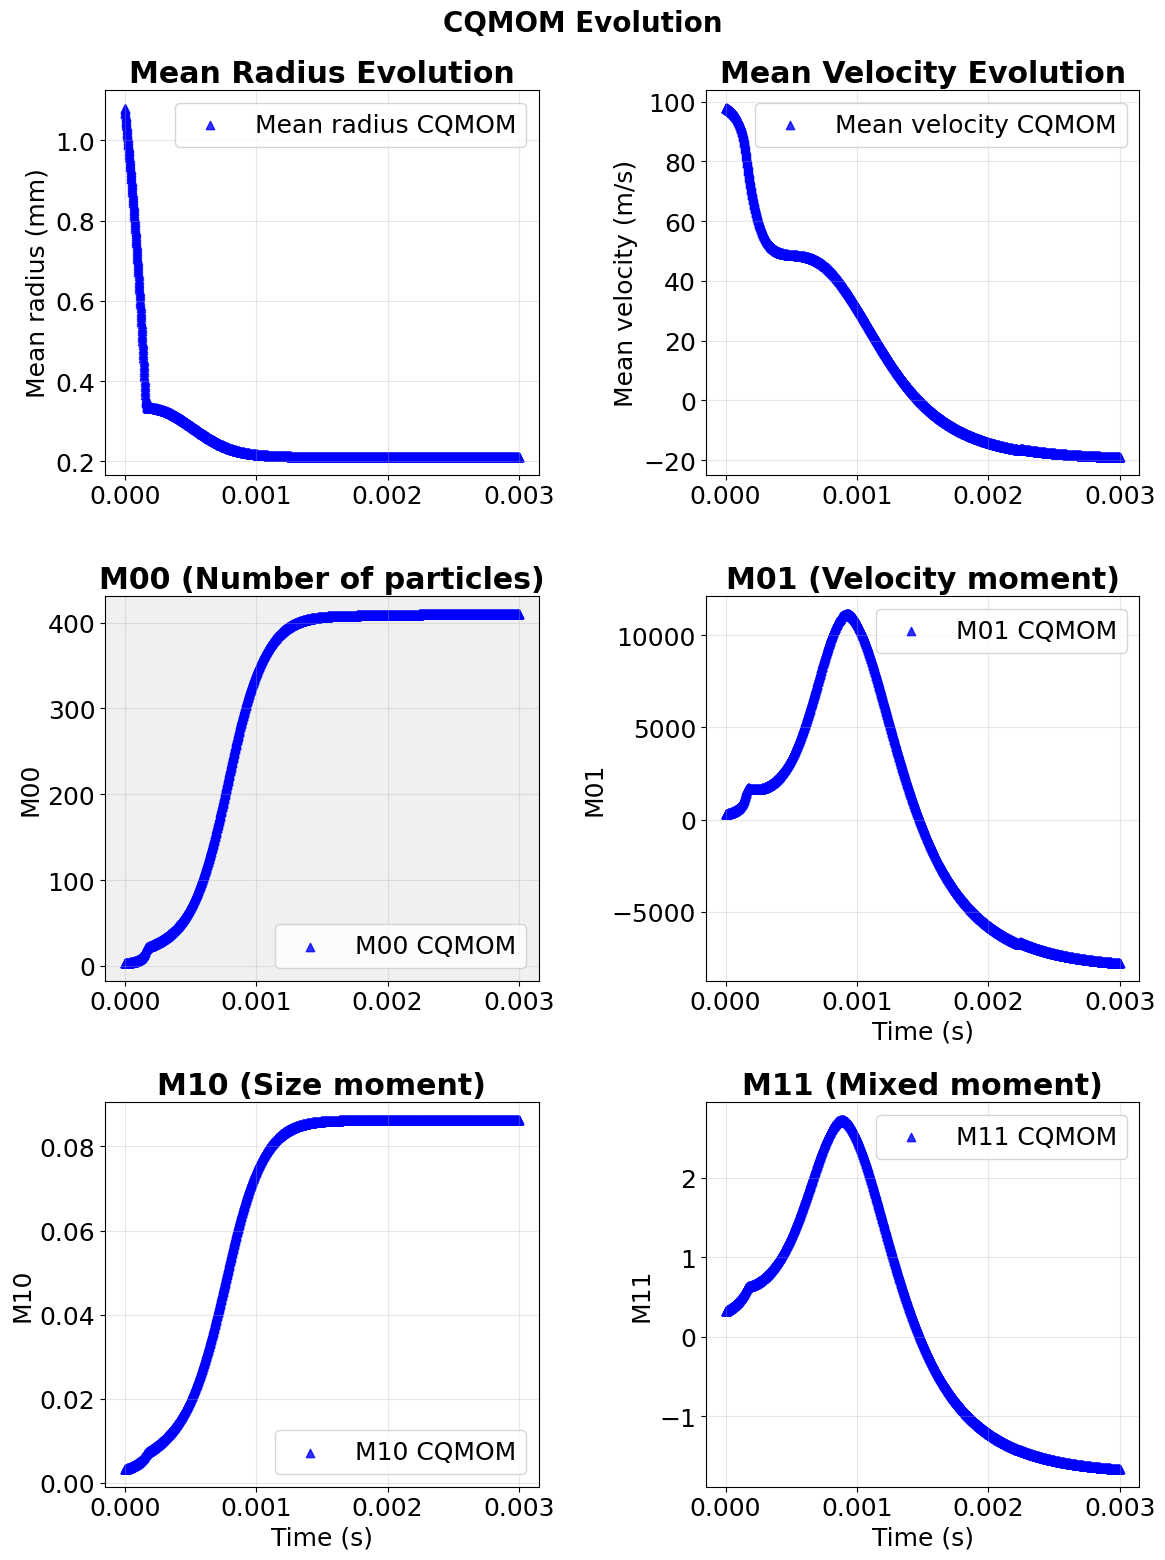

In [13]:

def run_simulation_only_CQMOM(initial_moments):
    """
    Run CQMOM simulation only (no MC)
    initial_moments: list of numpy arrays (one per initial droplet)
    """

    I = np.array([i for i in range(moments_idx[0])])
    J = np.array([j for j in range(moments_idx[1])])
    
    # Sum all initial moments from all droplets (like in run_simulation_parallel)
    current_moments = np.sum(initial_moments, axis=0)
    CQMOM_Moments = np.zeros((len(I), len(J), num_loops))

    for frame in range(num_loops):
        # Update the moments
        current_moments = update_moments(current_moments, N, t_span[0] + frame*time_step, dt=time_step)
        
        # Calculate the moments
        for i in I:
            for j in J:
                # ================================ CQMOM ================================
                CQMOM_Moments[i,j][frame] = current_moments[i,j]

    return CQMOM_Moments


def plot_only_CQMOM(CQMOM_Moments):
    """Plot only CQMOM moments and derived quantities in a 2x3 grid
    
    Grid layout:
    Row 1: Mean radius (mm), Mean velocity (m/s)
    Row 2: M00, M10  
    Row 3: M01, M11
    """
    
    # Calculate mean radius and velocity from moments
    with np.errstate(divide='ignore', invalid='ignore'):
        r_mean_CQMOM = np.where(CQMOM_Moments[0,0] != 0, CQMOM_Moments[1,0] / CQMOM_Moments[0,0], 0)
        u_mean_CQMOM = np.where(CQMOM_Moments[0,0] != 0, CQMOM_Moments[0,1] / CQMOM_Moments[0,0], 0)
    
    # Create figure with 2x3 grid - same height as PDF
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    fig.suptitle('CQMOM Evolution', fontsize=20, fontweight='bold')
    
    # Row 1: Mean radius and velocity - same style as moments with scatter
    axes[0,0].scatter(t_eval, r_mean_CQMOM*1000, marker='^', color='b', label='Mean radius CQMOM', alpha=0.8)
    axes[0,0].set_ylabel('Mean radius (mm)')
    axes[0,0].set_title('Mean Radius Evolution', fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()
    
    axes[0,1].scatter(t_eval, u_mean_CQMOM, marker='^', color='b', label='Mean velocity CQMOM', alpha=0.8)
    axes[0,1].set_ylabel('Mean velocity (m/s)')
    axes[0,1].set_title('Mean Velocity Evolution', fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()
    
    # Row 2: M00 and M01 - same style as PDF with scatter
    axes[1,0].scatter(t_eval, CQMOM_Moments[0,0], marker='^', color='b', label='M00 CQMOM', alpha=0.8)
    axes[1,0].set_ylabel('M00')
    axes[1,0].set_title('M00 (Number of particles)', fontweight='bold')
    # Highlight M00 like in PDF
    axes[1,0].set_facecolor('#f0f0f0')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend()
    
    axes[1,1].scatter(t_eval, CQMOM_Moments[0,1], marker='^', color='b', label='M01 CQMOM', alpha=0.8)
    axes[1,1].set_ylabel('M01')
    axes[1,1].set_xlabel('Time (s)')
    axes[1,1].set_title('M01 (Velocity moment)', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend()
    
    # Row 3: M10 and M11 - same style as PDF with scatter
    axes[2,0].scatter(t_eval, CQMOM_Moments[1,0], marker='^', color='b', label='M10 CQMOM', alpha=0.8)
    axes[2,0].set_ylabel('M10')
    axes[2,0].set_xlabel('Time (s)')
    axes[2,0].set_title('M10 (Size moment)', fontweight='bold')
    axes[2,0].grid(True, alpha=0.3)
    axes[2,0].legend()
    
    axes[2,1].scatter(t_eval, CQMOM_Moments[1,1], marker='^', color='b', label='M11 CQMOM', alpha=0.8)
    axes[2,1].set_ylabel('M11')
    axes[2,1].set_xlabel('Time (s)')
    axes[2,1].set_title('M11 (Mixed moment)', fontweight='bold')
    axes[2,1].grid(True, alpha=0.3)
    axes[2,1].legend()
    
    plt.tight_layout()
    plt.show()

CQMOM_Moments = run_simulation_only_CQMOM(initial_moments)
plot_only_CQMOM(CQMOM_Moments)



### Main Part

In [14]:
if __name__ == "__main__":
    # Run the simulation
    MC_Moments, CQMOM_Moments, Num_Droplets, final_droplet_sizes, final_velocities, final_moments = run_simulation_parallel()
    # Plot results
    plot_results(MC_Moments, CQMOM_Moments, Num_Droplets, final_droplet_sizes, final_velocities, final_moments)
    

    print(f"\nSimulation terminée avec succès!")
    print(f"Fichiers de sortie dans le dossier: {folder_name}")

Droplets completed:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\sebas\OneDrive\Documents\Stage recherche Atomisation Final\Quadrature\CQMOM.py:84: RuntimeWarning: invalid value encountered in scalar divide
  a[k - 1] = sigma[k, k + 1] / sigma[k, k] - sigma[k - 1, k] / sigma[k - 1, k - 1]
c:\Users\sebas\OneDrive\Documents\Stage recherche Atomisation Final\Quadrature\CQMOM.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  a[k - 1] = sigma[k, k + 1] / sigma[k, k] - sigma[k - 1, k] / sigma[k - 1, k - 1]
Droplets completed: 100%|██████████| 3/3 [08:04<00:00, 161.64s/it]


Deleted : radii_branch_3001887184.jsonl
Deleted : radii_branch_944435061.jsonl
Deleted : radii_branch_2942279437.jsonl

Plot saved: MTE_2D_Droplet_Breakup_notebook_output\Evolution_Moments_MTE_2D_Fragmentation.pdf

Simulation terminée avec succès!
Fichiers de sortie dans le dossier: MTE_2D_Droplet_Breakup_notebook_output
